In [1]:
import pickle
import os
import numpy as np

In [2]:
seed=34
vocab_size = 1000
embedding_dim = 100
lower = True

# Tokenizing and reading the data

i used a subset of the Signal Media One-million news articles dataset

In [4]:
with open('./data/vocabulary-embedding-content.pkl', 'rb') as fp:
    content = pickle.load(fp)

In [7]:
with open('./data/vocabulary-embedding-title.pkl', 'rb') as fp:
    title = pickle.load(fp)

In [8]:
if lower:
    title = [t.lower() for t in title]

In [6]:
if lower:
    content = [c.lower() for c in content]

In [9]:
content = [c.replace('\n', '') for c in content]

In [10]:
len(title), len(set(title))

(1000, 999)

In [11]:
len(content), len(set(content))

(1000, 1000)

# build Vocabulary 

In [12]:
from collections import Counter
from itertools import chain

In [13]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [14]:
vocab, vocabcount = get_vocab(title+content)

In [16]:
print vocab[:50]
print '...',len(vocab)

[u'the', u'to', u'and', u'of', u'a', u'in', u'for', u'is', u'on', u'that', u'with', u'at', u'as', u'was', u'it', u'be', u'from', u'are', u'by', u'this', u'have', u'will', u'has', u'i', u'you', u'an', u'he', u'but', u'not', u'or', u'we', u'more', u'their', u'his', u'they', u'new', u'said', u'who', u'all', u'about', u'can', u'its', u'your', u'our', u'one', u'been', u'which', u'also', u'out', u'up']
... 57345


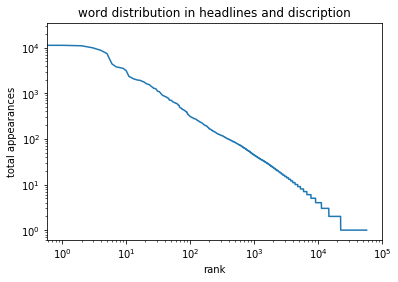

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

# Index words

In [18]:
empty = 0 
eos = 1
start_idx = eos+1

In [19]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [20]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word embedding

In [21]:
fname = 'glove.6B.%dd.txt'%embedding_dim

datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)

In [44]:
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    # path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

unzip:  cannot find or open /home/dhantha/.keras/datasets/glove.6B.zip, /home/dhantha/.keras/datasets/glove.6B.zip.zip or /home/dhantha/.keras/datasets/glove.6B.zip.ZIP.


In [22]:
glove_name = '/home/dhantha/Documents/Topic-Modeling-and-Text-Summarization-/data/glove.6B/glove.6B.100d.txt'

In [48]:
os.path

<module 'posixpath' from '/home/dhantha/anaconda3/envs/py36/lib/python3.6/posixpath.py'>

In [23]:
glove_n_symbols = !wc -l {'/home/dhantha/Documents/Topic-Modeling-and-Text-Summarization-/data/glove.6B/glove.6B.100d.txt'}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [25]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [26]:
glove_embedding_weights.std()

0.040815727600190289

In [27]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

# Embedding matrix

In [28]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

random-embedding/glove scale 0.0706949139514 std 0.0407891352641
number of tokens, in small vocab, found in glove and copied to embedding 939 0.939


In [29]:
glove_thr = 0.5

In [30]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [31]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 9359


In [32]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.500142740725 asserts => says
0.500128166948 bolstering => improve
0.500114109692 bans => law
0.500106890791 blankets => food
0.50010380263 mildly => bit
0.500054235681 dragons => games
0.500044418107 api => data
0.500035240099 outspoken => former
0.50002719986 satire => story
0.500006002631 marvelous => thing


In [33]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [35]:
Y = [[word2idx[token] for token in headline.split()] for headline in title]
len(Y)

1000

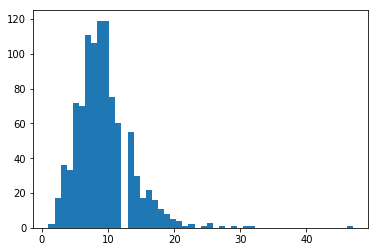

In [36]:
plt.hist(map(len,Y),bins=50);

In [37]:
X = [[word2idx[token] for token in d.split()] for d in content]
len(X)

1000

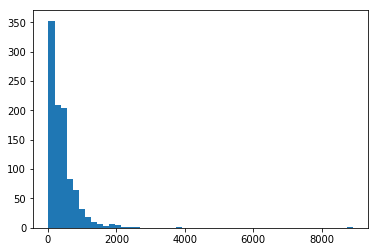

In [38]:
plt.hist(map(len,X),bins=50);

In [39]:
FN = 'vocabulary-embedding'

In [42]:
with open('./data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [43]:
with open('./data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)